# ALS of Heidelberg terrain demo

Notebook creator: Hannah Weiser, 2025

This demo uses a digital terrain model (DTM) of Heidelberg, Germany, which will be scanned by airborne laser scanning (ALS).

In [16]:
from pathlib import Path
import helios
from helios.platforms import DynamicPlatformSettings  # these should not have to be imported extra?
from helios.settings import OutputFormat, LogVerbosity, FullWaveformSettings # these should not have to be imported extra?
import numpy as np
import matplotlib.pyplot as plt

## Creating the virtual scene

In [2]:
# load geotiff
dtm = helios.ScenePart.from_tiff("../data/sceneparts/tiff/dem_hd.tif")
#scene
scene = helios.StaticScene(scene_parts=[dtm])

## Platform and Scanner

In [3]:
from helios.scanner import leica_als50_ii
from helios.platforms import sr22

scanner = leica_als50_ii()
platform = sr22()

## Scanner and platform settings

In [4]:
# these scanner settings will be shared between all legs
scanner_settings = helios.ScannerSettings(pulse_frequency=60_000,  # Hz
                                          scan_frequency=50,  # Hz
                                          scan_angle=60 * helios.units.deg,
                                          trajectory_time_interval=0.05  # s
                                         )
#Q: How to change detector settings (like maximum range) in a survey???

z = 1500.0  # m
speed = 150  # m/s

## Survey Route

In [5]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)

In [6]:
waypoints = [
    [474500, 5474500],
    [490000, 5474500],
    [474500, 5473500],
    [490000, 5473500]
]
for x, y in waypoints:
    platform_settings = DynamicPlatformSettings(x=x, y=y, z=z, speed_m_s=speed)
    leg = helios.Leg(scanner_settings=scanner_settings,
                    platform_settings=platform_settings)
    survey.add_leg(leg)

## Executing the survey

In [7]:
out_dir = survey.run(verbosity=LogVerbosity.VERBOSE, format=OutputFormat.XYZ)

## Visualizing the results

Now we can display a couple of 2D plots of the simulated point cloud.

In [11]:
print("Loading points from", Path(out_dir))

strip_1 = np.loadtxt(Path(out_dir) / "leg000_points.xyz")
strip_2 = np.loadtxt(Path(out_dir) / "leg001_points.xyz")
strip_3 = np.loadtxt(Path(out_dir) / "leg002_points.xyz")
traj_1 = np.loadtxt(Path(out_dir) / "leg000_trajectory.txt")
traj_2 = np.loadtxt(Path(out_dir) / "leg001_trajectory.txt")
traj_3 = np.loadtxt(Path(out_dir) / "leg002_trajectory.txt")
traj = np.vstack((traj_1[:, :3], traj_2[:, :3], traj_3[:, :3]))

Loading points from D:\Software\_helios_versions\helios_dev\example_notebooks\output\2025-10-28_22-13-56


Now we create two plots - one from above and one from the side - showing the point cloud colored by flight strip and the trajectory.

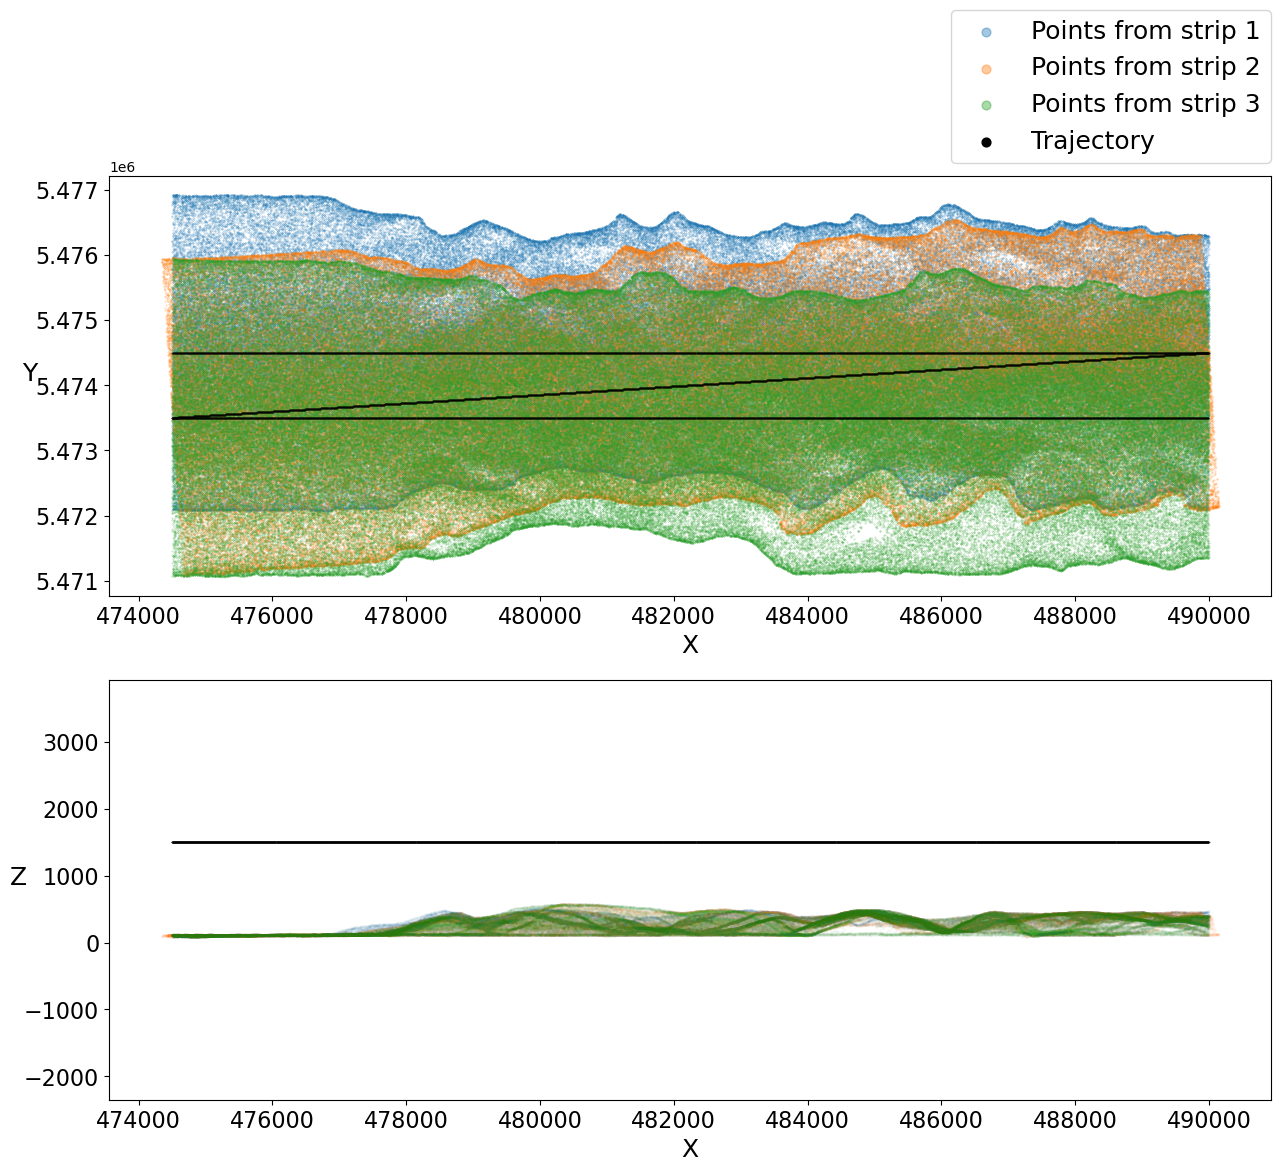

In [12]:
# two subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 12))

# view from above, colored by strip, including trajectory - for faster display, show only every 25th measurement
ax1.scatter(
    strip_1[::25, 0], strip_1[::25, 1], s=0.1, alpha=0.4, label="Points from strip 1"
)  # select X and Y coordinates
ax1.scatter(
    strip_2[::25, 0], strip_2[::25, 1], s=0.1, alpha=0.4, label="Points from strip 2"
)
ax1.scatter(
    strip_3[::25, 0], strip_3[::25, 1], s=0.1, alpha=0.4, label="Points from strip 3"
)
ax1.scatter(traj[:, 0], traj[:, 1], s=0.1, label="Trajectory", color="black")
ax1.tick_params(labelsize=16)
ax1.set_xlabel("X", fontsize=18)
ax1.set_ylabel("Y", fontsize=18, rotation=0)
ax1.legend(fontsize=18, markerscale=20, loc="lower right", bbox_to_anchor=(1.01, 1))

# use only every 50th measurement for better display
ax2.scatter(
    strip_1[::50, 0], strip_1[::50, 2], alpha=0.05, s=0.1, label="Points from strip 1"
)  # select X and Z coordinates
ax2.scatter(
    strip_2[::50, 0], strip_2[::50, 2], alpha=0.05, s=0.1, label="Points from strip 2"
)
ax2.scatter(
    strip_3[::50, 0], strip_3[::50, 2], alpha=0.05, s=0.1, label="Points from strip 3"
)
ax2.scatter(traj[:, 0], traj[:, 2], s=0.05, label="Trajectory", color="black")
ax2.tick_params(labelsize=16)
ax2.set_xlabel("X", fontsize=18)
ax2.set_ylabel("Z", fontsize=18, rotation=0)

plt.axis("equal")
# plt.legend(fontsize=18, markerscale=20)
plt.show()

Let's create another plot from above which is colored by altitude.

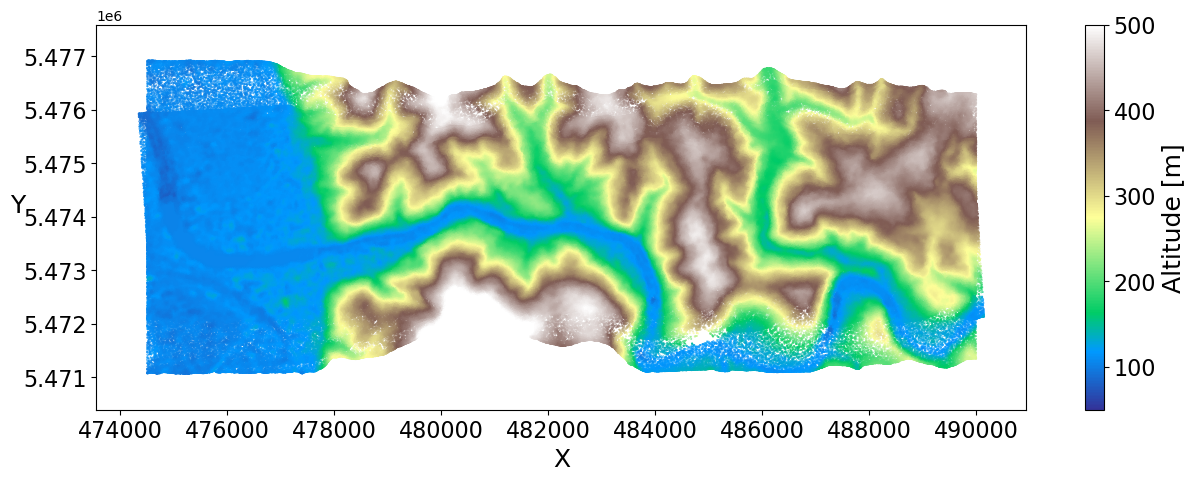

In [13]:
# view from above - colored by altitude

fig, ax = plt.subplots(figsize=(15, 5))

# select X and y coordinates
plot1 = ax.scatter(
    strip_1[::20, 0],
    strip_1[::20, 1],
    s=0.1,
    c=strip_1[::20, 2],
    cmap="terrain",
    vmin=50,
    vmax=500,
)
plot2 = ax.scatter(
    strip_2[::20, 0],
    strip_2[::20, 1],
    s=0.1,
    c=strip_2[::20, 2],
    cmap="terrain",
    vmin=50,
    vmax=500,
)
plot3 = ax.scatter(
    strip_3[::20, 0],
    strip_3[::20, 1],
    s=0.1,
    c=strip_3[::20, 2],
    cmap="terrain",
    vmin=50,
    vmax=500,
)
plt.axis("equal")
ax.tick_params(labelsize=16)
plt.xlabel("X", fontsize=18)
plt.ylabel("Y", fontsize=18, rotation=0)

cbar = plt.colorbar(plot1)
cbar.ax.tick_params(labelsize=16)
cbar.set_label("Altitude [m]", fontsize=18)
plt.show()

Finally, plot only a section of the point cloud to get a profile of the Neckar valley in Heidelberg.

In [14]:
# Section in direction of Y

xmin, ymin, xmax, ymax = [480000, 5472000, 480100, 5476000]

section_1 = strip_1[
    (strip_1[:, 0] > xmin)
    & (strip_1[:, 0] < xmax)
    & (strip_1[:, 1] > ymin)
    & (strip_1[:, 1] < ymax)
]
section_2 = strip_2[
    (strip_2[:, 0] > xmin)
    & (strip_2[:, 0] < xmax)
    & (strip_2[:, 1] > ymin)
    & (strip_2[:, 1] < ymax)
]
section_3 = strip_3[
    (strip_3[:, 0] > xmin)
    & (strip_3[:, 0] < xmax)
    & (strip_3[:, 1] > ymin)
    & (strip_3[:, 1] < ymax)
]

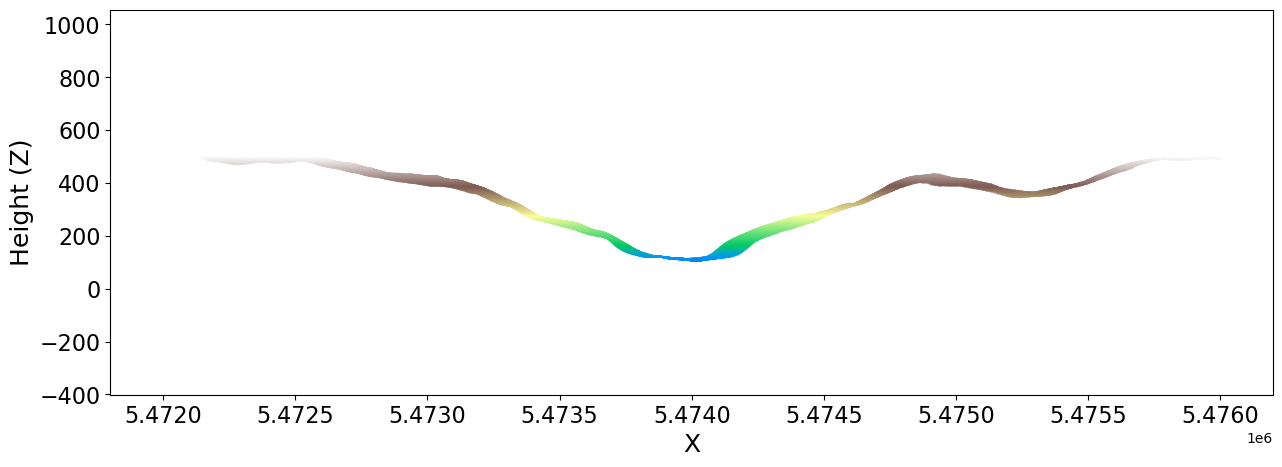

In [15]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()

ax.scatter(
    section_1[:, 1],
    section_1[:, 2],
    c=section_1[:, 2],
    cmap="terrain",
    s=0.01,
    vmin=50,
    vmax=500,
)
ax.scatter(
    section_2[:, 1],
    section_2[:, 2],
    c=section_2[:, 2],
    cmap="terrain",
    s=0.01,
    vmin=50,
    vmax=500,
)
ax.scatter(
    section_3[:, 1],
    section_3[:, 2],
    c=section_3[:, 2],
    cmap="terrain",
    s=0.01,
    vmin=50,
    vmax=500,
)
ax.tick_params(labelsize=16)

plt.xlabel("X", fontsize=18)
plt.ylabel("Height (Z)", fontsize=18, rotation=90)
plt.axis("equal")
plt.show()